## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.3.0+cu121'

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"

## 1. Getting Data

In [3]:
%%capture

import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("/data/")
image_path = data_path / "cat_v_dog"

# If the image folder doesn't exist, download it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# download and unzip cat_vs_dog data

from google.colab import drive
drive.mount('/content/drive/')
!unzip -u "/content/drive/My Drive/cat_v_dog.zip" -d "/data/cat_v_dog"

In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
valid_dir = image_path/ "valid"


train_dir, valid_dir

(PosixPath('/data/cat_v_dog/train'), PosixPath('/data/cat_v_dog/valid'))

Random image path: /data/cat_v_dog/train/dogs/dog.901.jpg
Image class: dogs
Image height: 411
Image width: 474


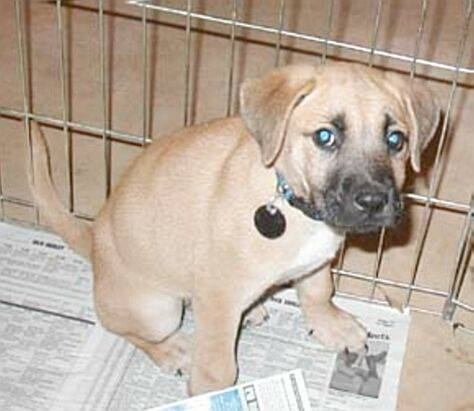

In [5]:
## Image visualization
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 2. Prepping and loading data
Transforming data into tensors and resizing the images.


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid',]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes


In [9]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 23000
     Root location: /data/cat_v_dog/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 2000
     Root location: /data/cat_v_dog/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [10]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d50c6426590>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7d50c64265c0>}

In [11]:
class_names,dataset_sizes

(['cats', 'dogs'], {'train': 23000, 'valid': 2000})

##Making our model and using transfer learning

In [12]:
from torchvision.models import resnet50
import torch.optim as optim
from torch.optim import lr_scheduler

In [13]:
model_rn50 = resnet50(weights='IMAGENET1K_V2')
num_ftrs = model_rn50.fc.in_features


ct = 0
for child in model_rn50.children():
  ct += 1
  if ct <= 8:
      for param in child.parameters():
          param.requires_grad = False

model_rn50.fc = nn.Linear(num_ftrs, len(class_names))

model_rn50 = model_rn50.to(device)



loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_rn50.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


## Train and test

In [14]:
%%capture
from torchsummary import summary
summary(model_rn50,(3,224,224))


In [15]:
import time
import tqdm

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def train_model(model, loss_criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()


  early_stopper = EarlyStopper(patience=3, min_delta=10)

  for epoch in tqdm.tqdm(range(num_epochs)):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'valid']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  preds =  torch.argmax(torch.softmax(outputs, dim=1), dim=1)
                  loss = loss_criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item()
              running_corrects += torch.sum(preds == labels.data)

          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          if phase=='valid':
            val_loss = epoch_loss
            if early_stopper.early_stop(val_loss):
              break

          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          # # deep copy the model
          best_acc=0

          if phase == 'valid' and epoch_acc > best_acc:
              best_acc = epoch_acc


      print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')



  # load best model weights
  # model.load_state_dict(torch.load(best_model_params_path))

  return model

In [20]:
model = train_model(model_rn50, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
train Loss: 0.0040 Acc: 0.9456


  4%|▍         | 1/25 [01:47<42:58, 107.43s/it]

valid Loss: 0.0011 Acc: 0.9870

Epoch 1/24
----------
train Loss: 0.0039 Acc: 0.9451


  8%|▊         | 2/25 [03:32<40:42, 106.18s/it]

valid Loss: 0.0009 Acc: 0.9885

Epoch 2/24
----------
train Loss: 0.0035 Acc: 0.9527


 12%|█▏        | 3/25 [05:19<39:05, 106.60s/it]

valid Loss: 0.0008 Acc: 0.9880

Epoch 3/24
----------
train Loss: 0.0037 Acc: 0.9489


 16%|█▌        | 4/25 [07:05<37:09, 106.19s/it]

valid Loss: 0.0008 Acc: 0.9870

Epoch 4/24
----------
train Loss: 0.0036 Acc: 0.9506


 20%|██        | 5/25 [08:54<35:41, 107.10s/it]

valid Loss: 0.0008 Acc: 0.9905

Epoch 5/24
----------
train Loss: 0.0035 Acc: 0.9527


 24%|██▍       | 6/25 [10:39<33:45, 106.62s/it]

valid Loss: 0.0008 Acc: 0.9865

Epoch 6/24
----------
train Loss: 0.0038 Acc: 0.9475


 28%|██▊       | 7/25 [12:28<32:08, 107.16s/it]

valid Loss: 0.0008 Acc: 0.9880

Epoch 7/24
----------
train Loss: 0.0035 Acc: 0.9514


 32%|███▏      | 8/25 [14:14<30:15, 106.80s/it]

valid Loss: 0.0008 Acc: 0.9900

Epoch 8/24
----------
train Loss: 0.0035 Acc: 0.9515


 36%|███▌      | 9/25 [16:01<28:30, 106.89s/it]

valid Loss: 0.0007 Acc: 0.9895

Epoch 9/24
----------
train Loss: 0.0034 Acc: 0.9545


 40%|████      | 10/25 [17:47<26:40, 106.67s/it]

valid Loss: 0.0007 Acc: 0.9895

Epoch 10/24
----------
train Loss: 0.0032 Acc: 0.9573


 44%|████▍     | 11/25 [19:37<25:06, 107.63s/it]

valid Loss: 0.0008 Acc: 0.9890

Epoch 11/24
----------
train Loss: 0.0033 Acc: 0.9540


 48%|████▊     | 12/25 [21:26<23:26, 108.19s/it]

valid Loss: 0.0007 Acc: 0.9890

Epoch 12/24
----------
train Loss: 0.0034 Acc: 0.9529


 52%|█████▏    | 13/25 [23:13<21:33, 107.80s/it]

valid Loss: 0.0007 Acc: 0.9890

Epoch 13/24
----------
train Loss: 0.0032 Acc: 0.9563


 56%|█████▌    | 14/25 [24:59<19:40, 107.36s/it]

valid Loss: 0.0007 Acc: 0.9885

Epoch 14/24
----------
train Loss: 0.0034 Acc: 0.9544


 60%|██████    | 15/25 [26:45<17:49, 106.96s/it]

valid Loss: 0.0008 Acc: 0.9865

Epoch 15/24
----------
train Loss: 0.0032 Acc: 0.9571


 64%|██████▍   | 16/25 [28:32<16:00, 106.77s/it]

valid Loss: 0.0008 Acc: 0.9885

Epoch 16/24
----------
train Loss: 0.0032 Acc: 0.9550


 68%|██████▊   | 17/25 [30:23<14:24, 108.08s/it]

valid Loss: 0.0007 Acc: 0.9890

Epoch 17/24
----------
train Loss: 0.0033 Acc: 0.9558


 72%|███████▏  | 18/25 [32:09<12:33, 107.64s/it]

valid Loss: 0.0008 Acc: 0.9875

Epoch 18/24
----------
train Loss: 0.0031 Acc: 0.9574


 76%|███████▌  | 19/25 [33:56<10:43, 107.28s/it]

valid Loss: 0.0007 Acc: 0.9890

Epoch 19/24
----------
train Loss: 0.0033 Acc: 0.9553


 80%|████████  | 20/25 [35:44<08:57, 107.47s/it]

valid Loss: 0.0008 Acc: 0.9870

Epoch 20/24
----------
train Loss: 0.0032 Acc: 0.9557


 84%|████████▍ | 21/25 [37:31<07:09, 107.38s/it]

valid Loss: 0.0007 Acc: 0.9885

Epoch 21/24
----------
train Loss: 0.0033 Acc: 0.9555


 88%|████████▊ | 22/25 [39:18<05:21, 107.20s/it]

valid Loss: 0.0007 Acc: 0.9890

Epoch 22/24
----------
train Loss: 0.0033 Acc: 0.9531


 92%|█████████▏| 23/25 [41:06<03:34, 107.42s/it]

valid Loss: 0.0008 Acc: 0.9870

Epoch 23/24
----------
train Loss: 0.0031 Acc: 0.9569


 96%|█████████▌| 24/25 [42:54<01:47, 107.67s/it]

valid Loss: 0.0007 Acc: 0.9895

Epoch 24/24
----------
train Loss: 0.0032 Acc: 0.9550


100%|██████████| 25/25 [44:41<00:00, 107.26s/it]

valid Loss: 0.0008 Acc: 0.9880

Training complete in 44m 41s
Best val Acc: 0.988000


In [21]:
PATH = './model_state_dict'
torch.save(model.state_dict(), PATH)